In [1]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [2]:
# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


In [3]:
import time
def octave_scale(original_img):
    start = time.time()

    OCTAVE_SCALE = 2

    img = tf.constant(np.array(original_img))
    base_shape = tf.shape(img)[:-1]
    float_base_shape = tf.cast(base_shape, tf.float32)
    loop = 1
    while loop:
        for n in range(-2, 3):
            try:
                new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

            
                img = tf.image.resize(img, new_shape).numpy()
                img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)
            except:
                loop = 0
    display.clear_output(wait=True)
    img = tf.image.resize(img, base_shape)
    img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
    show(img)

    end = time.time()
    end-start

In [68]:
import cv2
import os

castle = cv2.imread('castle.jpg')
castle = cv2.cvtColor(castle, cv2.COLOR_BGR2RGB)

butterfly = cv2.imread('butterfly.jpg')
butterfly = cv2.cvtColor(butterfly, cv2.COLOR_BGR2RGB)

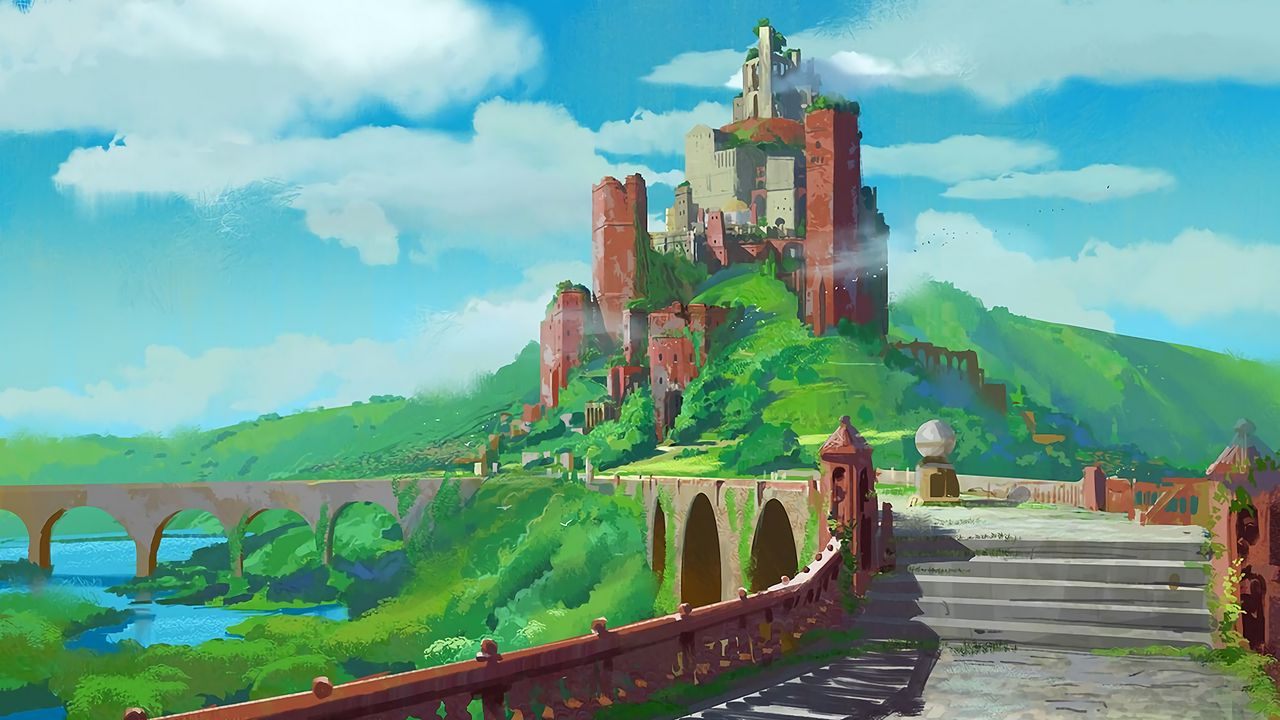

In [5]:
show((castle))

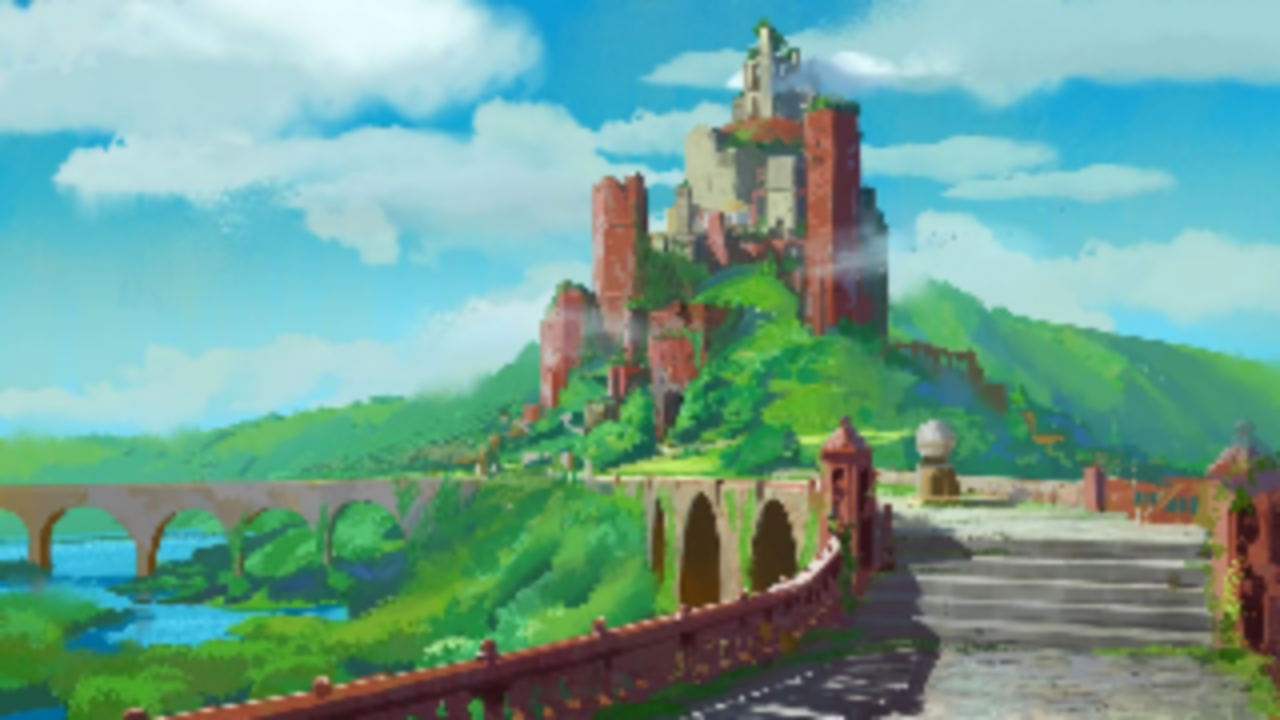

In [6]:
octave_scale(castle)

In [50]:
def run_deep_dream_with_octaves(img, name, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3, zoom_factor = 1.01,
                               zoom_bool = True, save = True, show_bool = True):
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    
    
    for octave in octaves:
    # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))
    
        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
            
            if step % 10 == 0:
                display.clear_output(wait=True)
                print ("Octave {}, Step {}".format(octave, step))
                
                if show_bool:
                    show(deprocess(img))
            if save:
                save_image(deprocess(img), str(name) + " " + str(step))
            if zoom_bool:
                img = clipped_zoom(img, zoom_factor)
            
    result = deprocess(img)
    return result

In [42]:
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [43]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [44]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift=shift, axis=[0,1])
    return shift, img_rolled

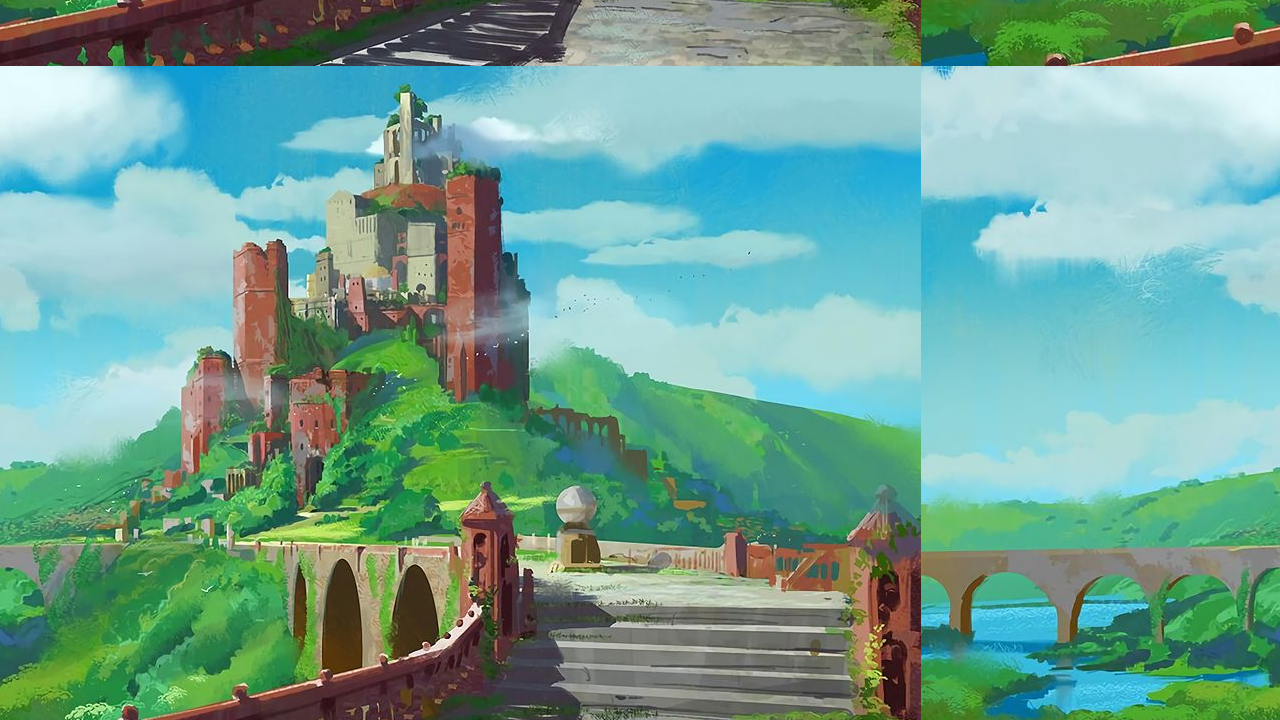

In [45]:
show(random_roll(castle, 512)[1])

In [46]:
def save_image(img, file_name = 'test'):
    if type(img) != np.ndarray:
        img = img.numpy()
    #img = img * 255
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except:
        pass
    #img = tf.image.resize(img, ((500,500)))
    #img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
    cv2.imwrite('outputs/' + file_name + '.jpg', img)

In [47]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
    )
    def __call__(self, img, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)

        # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)

        # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
            # Calculate the gradients for this tile.
                with tf.GradientTape() as tape:
                    # This needs gradients relative to `img_rolled`.
                    # `GradientTape` only watches `tf.Variable`s by default.
                    tape.watch(img_rolled)

                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                    loss = calc_loss(img_tile, self.model)

                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients

In [48]:
import cv2

noise = np.random.randint(0, 255,(500,500, 3)) 
black = np.full((500,500,3), 0)

In [11]:
save_image(noise, 'noise')

In [16]:
# Maximize the activations of these layers

#base_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet')
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
#base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')


In [17]:
[layer.name for layer in base_model.layers if 'mixed' in layer.name]  

['mixed0',
 'mixed1',
 'mixed2',
 'mixed3',
 'mixed4',
 'mixed5',
 'mixed6',
 'mixed7',
 'mixed8',
 'mixed9_0',
 'mixed9',
 'mixed9_1',
 'mixed10']

Octave 0, Step 330


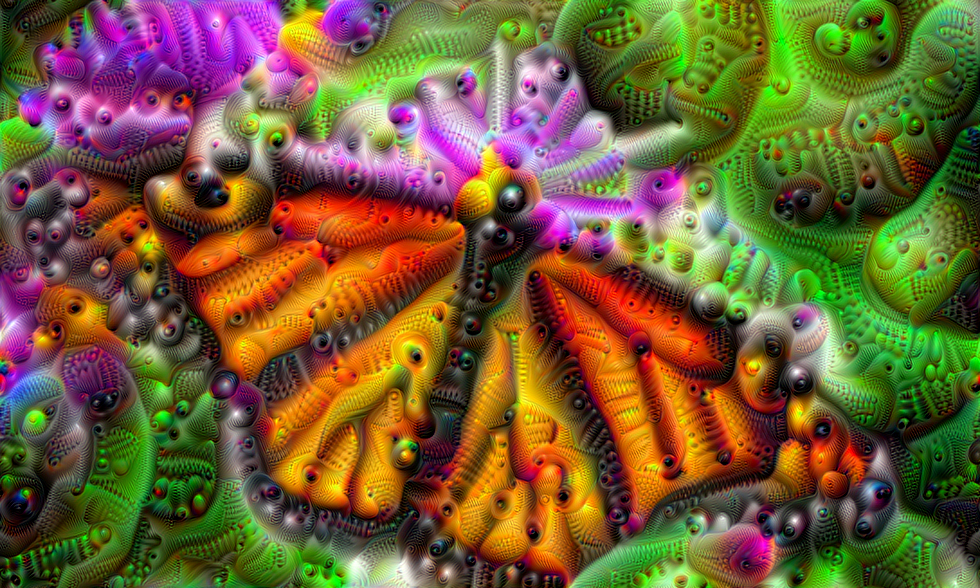

In [83]:
#layers = [layer.name for layer in base_model.layers if 'block' in layer.name and '_conv' in layer.name]
#layers = [layer.name for layer in base_model.layers if 'concat' in layer.name]
#layers = [layer.name for layer in base_model.layers if '_conv' in layer.name]
layers = [layer.name for layer in base_model.layers if 'mixed' in layer.name]      ## Inception

layers = [base_model.get_layer(name).output for name in layers]
layers = layers[:-6]


# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=[layers[3], layers[1]])        ## Layer Selection
get_tiled_gradients = TiledGradients(dream_model)



## Hyperparameter Selection
## spo = 500 and step_s = 0.001 seems really good actually

## For noise, Consider 500 spo, 0.02 step_s, lower octaves
steps_per_octave=340
step_size=0.002
octaves=range(-4,1)
octave_scale=1.8
zoom_factor = 1.01
zoom_bool = False
save = False
show_bool = True

noise_img = run_deep_dream_with_octaves(butterfly, 'Castle', steps_per_octave=steps_per_octave, step_size=step_size,  
                                octaves=octaves, octave_scale=octave_scale, zoom_factor = zoom_factor, 
                                        zoom_bool = zoom_bool, save = save, show_bool = show_bool)


"""
IMPLEMENT SAVING YAML FILE OF HYPERPARAMETERS when save = True

Change save boolean to a directory, where all files will go
Make sure to change the file name for each octave, so that gifs can be made for each octave

Add Gif Generator that references target directory and create gif at outputdirectory
"""
if save:
    pass

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/path/to/image_*.png"
fp_out = "/path/to/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

## Evaluate All Layers

Octave -1, Step 90


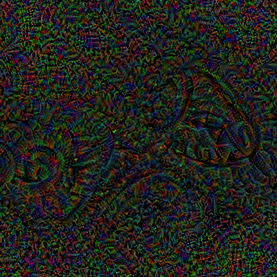

mixed6/concat_1:0


In [31]:
layers = [layer.name for layer in base_model.layers if 'mixed' in layer.name]
layers = [base_model.get_layer(name).output for name in layers]
layers = layers[:-6]

for layer in layers:
    try:
        dream_model = tf.keras.Model(inputs=base_model.input, outputs=[layer])        ## Layer Selection
        get_tiled_gradients = TiledGradients(dream_model)
        dream = run_deep_dream_with_octaves(black, 'InceptionV3' + "_" + layer.name, steps_per_octave=100, step_size=0.02,  
                                    octaves=range(-4,0), octave_scale=1.8, zoom = 1.001, zoom_bool = False, save = True, show_bool = True)
        save_image(dream, 'InceptionV3_'+ str(layer.name).split('/')[0])
        print(layer.name)
    except:
        print("Error at ", layer.name)